In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter


In [2]:
path = f'.'

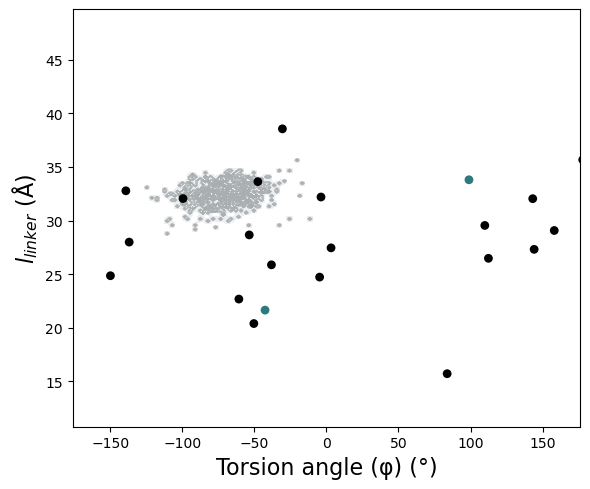

In [6]:
BINS = 200
SYSTEMS = ['apo_l_1000']  

HEX_COLORS = {
    'holo_l': '#A9AEB1',
    'holo_p': '#636A6E',
    'apo_l':  '#A9AEB1',
    'apo_p':  '#636A6E',
}

DIHEDRAL_EDGES = np.linspace(-176, 176, BINS)
DISTANCE_EDGES = np.linspace(10.75, 49.75, BINS)

# NMR scatter sources
NMR_FILE_HOLO = 'holo.txt'
NMR_FILE_APO  = 'apo.txt'


def prepare_contour_data(dihedrals, distances, dihedral_edges, distance_edges):
    """Builds 2D binned density and smooths it for contour plotting."""
    histogram, xedges, yedges = np.histogram2d(
        dihedrals, distances, bins=[dihedral_edges, distance_edges]
    )
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    Z = histogram.T
    Z_smooth = gaussian_filter(Z, sigma=0.2)
    return X, Y, Z_smooth

def single_color_cmap(hex_color, name):
    """Colormap that renders as a single flat color."""
    return LinearSegmentedColormap.from_list(name, [hex_color, hex_color])

def system_prefix(system_name):
    """Extracts the prefix like 'holo_p' from 'holo_p_p'."""
    return "_".join(system_name.split("_")[:2])

def load_xy_from_txt(fname):
    """Return (x, y) from a 2- or 3-column text file; ignores extra columns."""
    arr = np.loadtxt(fname)
    x = arr[:, 0]
    y = arr[:, 1]
    z = arr[:, 2] if arr.shape[1] >= 3 else None
    return x, y, z

def plot_nmr_scatter(ax, X, Y, Zlike=None, **kwargs):
    """Scatter NMR points; if Zlike provided, teal where Z==6 else black."""
    if Zlike is None:
        colors = 'black'
    else:
        colors = np.where(np.asarray(Zlike) == 6, '#2C7A7B', 'black')
    ax.scatter(X, Y, c=colors, s=40, linewidths=0.0, zorder=1.5, **kwargs)

X_holo, Y_holo, Z_holo = load_xy_from_txt(NMR_FILE_HOLO)
X_apo,  Y_apo,  Z_apo  = load_xy_from_txt(NMR_FILE_APO)


fig = plt.figure(figsize=(6, 5))
gs = gridspec.GridSpec(1, 1, figure=fig)
axes = [fig.add_subplot(gs[0, 0])]

for idx, system in enumerate(SYSTEMS):
    ax = axes[idx]
    file_name = f"dihedral_distance_{system}.txt"  # -> dihedral_distance_apo_l_1000.txt

    # Load density data
    data = np.loadtxt(file_name)
    dihedrals = data[:, 0]
    distances = data[:, 1]

    # Prepare smoothed 2D density
    X, Y, Z = prepare_contour_data(dihedrals, distances, DIHEDRAL_EDGES, DISTANCE_EDGES)

    # Mask minimum bin (usually zeros) so background stays clear
    min_val = np.nanmin(Z)
    Z = Z.astype(float)
    Z[Z == min_val] = np.nan

    # Choose color by system prefix
    prefix = system_prefix(system)  # e.g., 'apo_l'
    base_hex = HEX_COLORS.get(prefix)
    if base_hex is None:
        for key in HEX_COLORS:
            if system.startswith(key):
                base_hex = HEX_COLORS[key]
                break
    cmap = single_color_cmap(base_hex, f"cmap_{system}")

    # Draw density as a soft background
    ax.contourf(X, Y, Z, levels=200, cmap=cmap, alpha=0.2, zorder=0.8)

    # Overlay NMR scatter (apo system -> APO points)
    if system.startswith('holo'):
        plot_nmr_scatter(ax, X_holo, Y_holo, Z_holo)
    else:
        plot_nmr_scatter(ax, X_apo, Y_apo, Z_apo)

    # Formatting
    ax.set_xlim(DIHEDRAL_EDGES.min(), DIHEDRAL_EDGES.max())
    ax.set_ylim(DISTANCE_EDGES.min(), DISTANCE_EDGES.max())
    ax.set_xlabel('Torsion angle (φ) (°)', fontsize=16)
    ax.set_ylabel(r'$l_{\mathit{linker}}$ (Å)', fontsize=16)

plt.tight_layout()
plt.savefig('dihedral_distance_plot.png', format='png', dpi=1200)
plt.show()
